<a href="https://colab.research.google.com/github/MiraPurkrabek/vs3-cnn-labs/blob/main/Mira_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kornia timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 517 kB 4.7 MB/s 
     |████████████████████████████████| 512 kB 68.1 MB/s 


In [2]:
from fastai.vision.all import *

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import cv2
import seaborn as sns
import torch
torch.set_num_threads(1)
import torch.nn as nn
import torch.nn.functional as F
import torchvision as tv
import kornia as K
from tqdm import tqdm_notebook as tqdm
from time import time

def imshow_torch(tensor,figsize=(8,6), *kwargs):
    plt.figure(figsize=figsize)
    plt.imshow(K.tensor_to_image(tensor), *kwargs)
    return

def imshow_torch_channels(tensor, dim = 1, *kwargs):
    num_ch = tensor.size(dim)
    fig=plt.figure(figsize=(num_ch*5,5))
    tensor_splitted = torch.split(tensor, 1, dim=dim)
    for i in range(num_ch):
        fig.add_subplot(1, num_ch, i+1)
        plt.imshow(K.tensor_to_image(tensor_splitted[i].squeeze(dim)), *kwargs)
    return

In [ ]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz
!tar -xzf imagenette2-160.tgz

In [ ]:
dls = ImageDataLoaders.from_folder('imagenette2-160/',
                                   valid='val', 
                                   item_tfms=RandomResizedCrop(128, min_scale=0.35),
                                   batch_tfms=Normalize.from_stats(*imagenet_stats))

# if a string is passed into the model argument, it will now use timm (if it is installed)
learn = vision_learner(dls, 'resnet18',  metrics=error_rate)


In [ ]:
dls.show_batch()

In [ ]:
learn.lr_find()

In [ ]:
learn.fine_tune(5,base_lr = 2e-4, freeze_epochs=2, cbs=[ShowGraphCallback()])

# Task

Beer vs Trdelnik recognition

In [22]:
from fastai.data.all import *
from fastai.vision.all import *

fnames = get_image_files('data/')

def label_func(fname):
    return str(fname).split('/')[1]

In [23]:


dblock = DataBlock(get_items = get_image_files,
                   get_y     = label_func)

dsets = dblock.datasets('data/')
len(dsets.train), len(dsets.valid)



(213, 53)

In [24]:
dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(),
                   item_tfms = Resize(224))

dsets = dblock.datasets('data')
dsets.train[0]

(PILImage mode=RGB size=159x318, TensorCategory(1))

In [25]:
dsets.vocab

['beer', 'trdelnik']

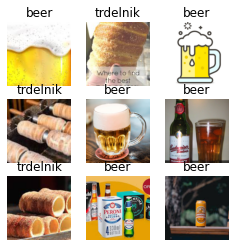

In [42]:
dls = dblock.dataloaders("data", bs=16)
dls.show_batch(max_n=9, figsize=(4,4))

In [43]:
# learn = Learner(dls, xresnet34(n_out=2), metrics=accuracy)
learn = vision_learner(dls, 'resnet50',  metrics=accuracy)

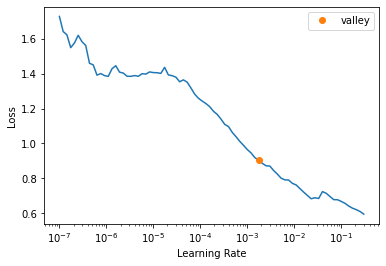

In [44]:
optimal_lr = learn.lr_find()

In [62]:
learn.fine_tune(20, base_lr = (optimal_lr.valley)/10)
# learn.fine_tune(10, base_lr = optimal_lr.valley, freeze_epochs=2, cbs=[ShowGraphCallback()])

epoch,train_loss,valid_loss,accuracy,time
0,0.022707,6.507797,0.943396,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.028738,10.745049,0.943396,00:03
1,0.034993,6.125639,0.943396,00:03
2,0.044045,6.385649,0.943396,00:03
3,0.030112,1.589834,0.943396,00:03
4,0.044114,2.077543,0.962264,00:03
5,0.047933,1.079706,0.962264,00:03
6,0.050533,3.890187,0.962264,00:03
7,0.038199,20.254108,0.943396,00:03
8,0.034811,19.029463,0.943396,00:03
9,0.028067,11.533654,0.962264,00:03


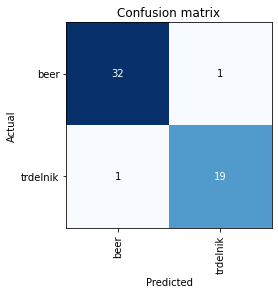

In [63]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

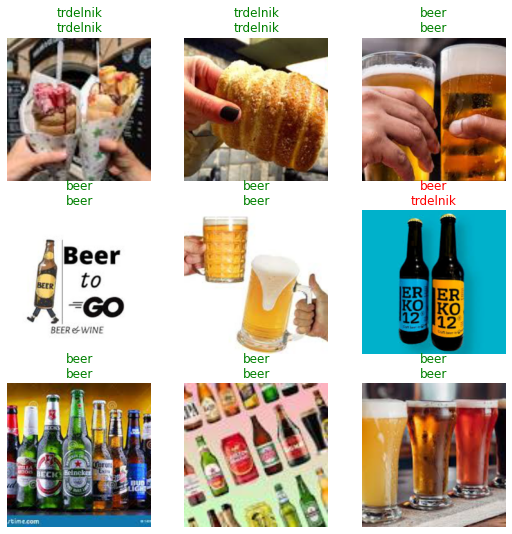

In [64]:
learn.show_results()

In [66]:
!wget http://cmp.felk.cvut.cz/~mishkdmy/bt/rc.tar.gz && tar -xzf rc.tar.gz

--2022-07-25 13:41:19--  http://cmp.felk.cvut.cz/~mishkdmy/bt/rc.tar.gz
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 645058 (630K) [application/x-gzip]
Saving to: ‘rc.tar.gz’

rc.tar.gz           100%[===================>] 629.94K  1.04MB/s    in 0.6s    

2022-07-25 13:41:20 (1.04 MB/s) - ‘rc.tar.gz’ saved [645058/645058]



In [79]:
import os

for img_name in os.listdir("test_data"):
  if img_name.endswith(".jpg"):
    img_path = os.path.join("test_data", img_name)
    img=PILImage(load_image(img_path))
    pred = learn.predict(img)
    print(pred, img_name)
    # plt.imshow(img)

('beer', TensorBase(0), TensorBase([9.9999e-01, 4.9726e-06])) beer.jpg


('beer', TensorBase(0), TensorBase([0.9612, 0.0388])) c1.jpg


('trdelnik', TensorBase(1), TensorBase([1.1570e-04, 9.9988e-01])) rc.jpg


('beer', TensorBase(0), TensorBase([9.9981e-01, 1.8701e-04])) c4.jpg


('trdelnik', TensorBase(1), TensorBase([0.0250, 0.9750])) c3.jpg


('trdelnik', TensorBase(1), TensorBase([1.0373e-06, 1.0000e+00])) r1.jpg


('trdelnik', TensorBase(1), TensorBase([0.0071, 0.9929])) c2.jpg


('trdelnik', TensorBase(1), TensorBase([1.0123e-06, 1.0000e+00])) r2.jpg
